In [1]:
import numpy as np
import glob
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import sobel
from sklearn.model_selection import train_test_split

SIZE = 128

In [2]:
data_img = []
data_label = [] 
for dir_path in glob.glob("Dataset/*"):
    label = dir_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
#         print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (SIZE, SIZE))
        data_img.append(img)
        data_label.append(label)
        
data_img = np.array(data_img)
data_label = np.array(data_label)

normal
potholes


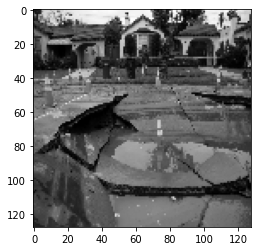

In [3]:
plt.imshow(data_img[355], cmap='gray')

In [4]:
def feature_extractor(dataset):
    new_dataset = []
    for image in dataset:
        image_flatten = image.flatten()
        new_dataset.append(image_flatten)
    new_dataset = np.array(new_dataset)
    # normalisasi
    new_dataset = new_dataset / 255.0
    return new_dataset

In [5]:
feature_img = feature_extractor(data_img)

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_label)
data_encoded = le.transform(data_label)

x_train, x_test, y_train, y_test = train_test_split(feature_img, data_encoded, test_size=0.2)

In [7]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')
SVM_model.fit(x_train, y_train)

SVC(decision_function_shape='ovo')

In [8]:
test_prediction = SVM_model.predict(x_test)

In [9]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

Accuracy =  0.7578125


<AxesSubplot:>

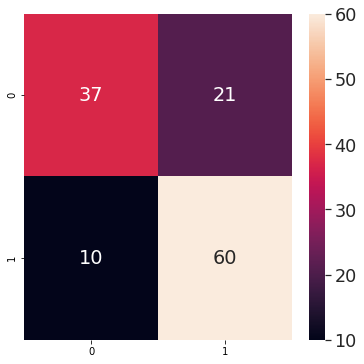

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)
